# Which Sketch Should I Use?

*This section shares the title of Ethan's [blog post](https://www.ethanepperly.com/index.php/2023/11/27/which-sketch-should-i-use/), which inspired the design of the experiments we conduct here.*


In the past several sections, we have seen several oblivious sketching methods. 
Which one should we use?

In short, we recommend [Sparse Sketches](./sparse-sketch.md) as a good default choice. 
In settings where dense matrix-matrix multiplication is highly optimized (e.g. when working with relatively small matrices on GPUs), dense sketches may be preferable. 

In [1]:
import numpy as np
import scipy as sp
from scipy import fft,sparse
import pandas as pd
import time
import matplotlib.pyplot as plt

In [2]:
def gaussian_sketch(n,k,rng):
    S = rng.randn(k,n) / np.sqrt(k)
    return S

class trig_sketch():
    
    def __init__(self,n,k,rng):

        self.shape = (k,n)
        self.pi = rng.permutation(n)
        self.E = 2*rng.randint(0,2,n)-1
        self.R = rng.choice(n,size=k,replace=False)

    def __matmul__(self,A):

        A_loc = A.A if sp.sparse.issparse(A) else A
        return np.sqrt(self.shape[1]/self.shape[0])*sp.fft.dct(self.E[:,None]*A_loc[self.pi],norm='ortho',axis=0)[self.R]
    
def sparse_stack_sketch(n,k,zeta,rng):

    k_rem = k%zeta
    k_loc = k//zeta+(k_rem>0)

    C = np.random.randint(0,k_loc,size=(n,zeta))
    if k_rem > 0:
        C[:,-1] = np.random.randint(0,k_rem,size=n)
    C += np.arange(0,k,k_loc)

    indices = C.flatten()
    values = np.sqrt(1/zeta)*(2*np.random.randint(2,size=n*zeta)-1)
    indptr = np.arange(0,n+1)*zeta
    S = sp.sparse.csc_matrix ((values,indices,indptr),shape=(k,n))

    return S

In [3]:
n = 10_000
d = 50

A = np.random.randn(n,d)
A_s = sp.sparse.random(n,d, density=0.05)

In [4]:
sketch_methods = {
    'Gaussian': {
        'func': lambda k,rng: gaussian_sketch(n,k,rng),
    },
    'Trig': {
        'func': lambda k,rng: trig_sketch(n,k,rng),
    },
    'Sparse (zeta=4)': {
        'func': lambda k,rng: sparse_stack_sketch(n,k,4,rng),
    },
    'Sparse (zeta=8)': {
        'func': lambda k,rng: sparse_stack_sketch(n,k,8,rng),
    },
}


## Generate / Apply Cost

In [5]:
k = 2*d

n_repeat = 10

results = []

for method_name, method_info in sketch_methods.items():
    # Time the method
    start = time.time()
    for i in range(n_repeat):
        rng = np.random.RandomState(i)
        S = method_info['func'](k,rng)
    end = time.time()
    
    avg_gen_time = (end - start) / n_repeat

    start = time.time()
    for i in range(n_repeat):
        rng = np.random.RandomState(i)
        S = method_info['func'](k,rng)
        S@A
    end = time.time()
    
    avg_dense_apply_time = (end - start) / n_repeat - avg_gen_time

    start = time.time()
    for i in range(n_repeat):
        rng = np.random.RandomState(i)
        S = method_info['func'](k,rng)
        S@A_s
    end = time.time()
    
    avg_sparse_apply_time = (end - start) / n_repeat - avg_gen_time
    
    # Compute accuracy metrics
    results.append({
        'method': method_name,
        'gen. time (s)': avg_gen_time,
        'apply to dense time (s)': avg_dense_apply_time,
        'apply to sparse time (s)': avg_sparse_apply_time,
    })


# Create DataFrame and compute relative performance
results_df = pd.DataFrame(results)

# Display results with formatting
results_df.style.format({
    'gen. time (s)': '{:1.2e}',
    'apply to dense time (s)': '{:1.2e}',
    'apply to sparse time (s)': '{:1.2e}'
})

,method,gen. time (s),apply to dense time (s),apply to sparse time (s)
0,Gaussian,6.65e-02,1.34e-02,1.24e-02
1,Trig,1.65e-03,1.85e-02,1.54e-02
2,Sparse (zeta=4),2.65e-03,2.68e-03,5.79e-03
3,Sparse (zeta=8),4.80e-03,4.28e-03,5.97e-03


## Distortion

In [6]:
U,_ = np.linalg.qr(A)

U_hard = np.zeros((n,d))
U_hard[:d] = np.eye(d)

In [7]:
sketch_problems = {
    'typical': {
        'U': U,
    },
    'hard': {
        'U': U_hard,
    },
}

ks = np.geomspace(2*d,1000,10,dtype=int)

n_repeat = 1

results = {}

for problem_name,problem_info in sketch_problems.items():

    U_problem = problem_info['U']
    for method_name, method_info in sketch_methods.items():


        distortion = np.zeros((n_repeat,len(ks)))
        for i in range(n_repeat):
            rng = np.random.RandomState(i)
            for j,k in enumerate(ks):
            
                S = method_info['func'](k,rng)
                Y = S@U_problem

                s = np.linalg.svd(Y,compute_uv=False)
                distortion[i,j] = max(s[0]-1,1-s[-1]) 

        results[problem_name,method_name] = {
            'distortion': distortion,
        }

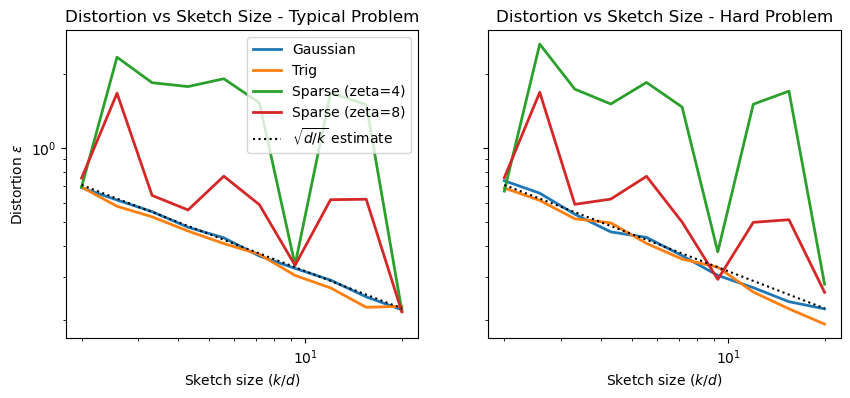

In [8]:
σ = 0.05
fig, axs = plt.subplots(1,len(sketch_problems),figsize=(10, 4),sharey=True)

# Handle case where we only have one subplot
if len(sketch_problems) == 1:
    axs = [axs]

for i, (problem_name, problem_info) in enumerate(sketch_problems.items()):
    ax = axs[i]
    
    for method_name, method_info in sketch_methods.items():
        # Get the distortion data for this problem and method
        distortion = results[problem_name, method_name]['distortion']
        
        bot, mid, top = np.quantile(distortion, [σ, .5, 1-σ], axis=0)
        ax.plot(ks/d, mid, label=method_name, linewidth=2)
        ax.fill_between(ks/d, bot, top, alpha=.2)

    # Theoretical bound
    ax.plot(ks/d, np.sqrt(d/ks), ls=':', color='k', label=r'$\sqrt{d/k}$ estimate')

    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_xlabel('Sketch size ($k/d$)')
    ax.set_title(f'Distortion vs Sketch Size - {problem_name.capitalize()} Problem')

axs[0].set_ylabel(rf'Distortion $\varepsilon$')
axs[0].legend()
